In [1]:
%matplotlib inline

In [120]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import GPy
from IPython.display import display
import scipy
from scipy import stats

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

The likelihood is $P(X, \mu, \sigma) = \prod_{i=1}^{n} \big( 0.7N(x_i | 0, 4^2) + 0.3N(x_i | \mu, \sigma^2)  \big)$

The log-likelihood is hence: $\log P(X, \mu, \sigma) = \sum_{i=1}^{n} \log \big( 0.7N(x_i | 0, 4^2) + 0.3N(x_i | \mu, \sigma^2)  \big)$

In [42]:
BACKGROUND_MEAN = 0
BACKGROUND_STDDEV = 4
BACKGROUND_WEIGHT = 0.7

MU_PRIOR_MEAN = 0
MU_PRIOR_SIGMA = 5
SIGMA_PRIOR_SHAPE = 2
SIGMA_PRIOR_SCALE = 1


def log_likelihood(X, mu, sigma):
    background = stats.norm.logpdf(X, BACKGROUND_MEAN, BACKGROUND_STDDEV) * BACKGROUND_WEIGHT
    unknown = stats.norm.logpdf(X, mu, sigma) * (1 - BACKGROUND_WEIGHT)
    return np.sum(background + unknown)

def likelihood(X, mu, sigma):
    return np.exp(log_likelihood(X, mu, sigma))

def unnormalized_logposterior(X, mu, sigma):
    return np.sum((log_likelihood(X, mu, sigma), 
                  stats.norm.logpdf(mu, MU_PRIOR_MEAN, MU_PRIOR_SIGMA),
                  stats.gamma.logpdf(sigma, SIGMA_PRIOR_SHAPE, 0, SIGMA_PRIOR_SCALE)))

def unnormalized_posterior(X, mu, sigma):
    return np.exp(unnormalized_logposterior(X, mu, sigma))

In [128]:
X = np.array([-4.127935, 3.046302, -10.77442, 3.305034, -6.985155, 5.536106, 1.294746, 7.638998,
            -5.650118, -4.478067, -0.4551435, -3.969413, -0.4225518, -2.462094, 1.886675,
            3.095567, 4.310003, 0.8548273, 4.368213, -2.152332])

delta = 0.1
mu_range = np.arange(-5, 5, delta)
sigma_range = np.arange(2, 8, delta)
MU, SIGMA = np.meshgrid(mu_range, sigma_range)
unlp = np.array([unnormalized_posterior(X, mu, sigma) for (mu, sigma) in zip(MU.flat, SIGMA.flat)])
reshaped_unlp = unlp.reshape(MU.shape)

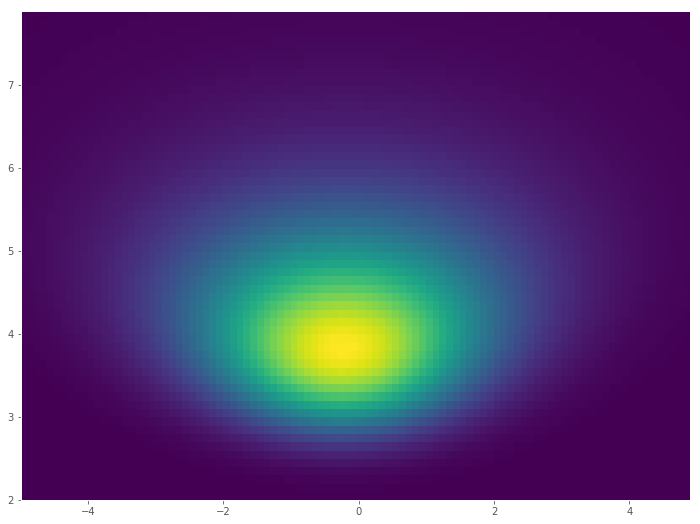

In [129]:
plt.figure(figsize=(12, 9))
plt.pcolormesh(mu_range, sigma_range, reshaped_unlp) #, 
#                norm=colors.LogNorm(vmin=reshaped_unlp.min(), vmax=reshaped_unlp.max()))#, cmap='hot')

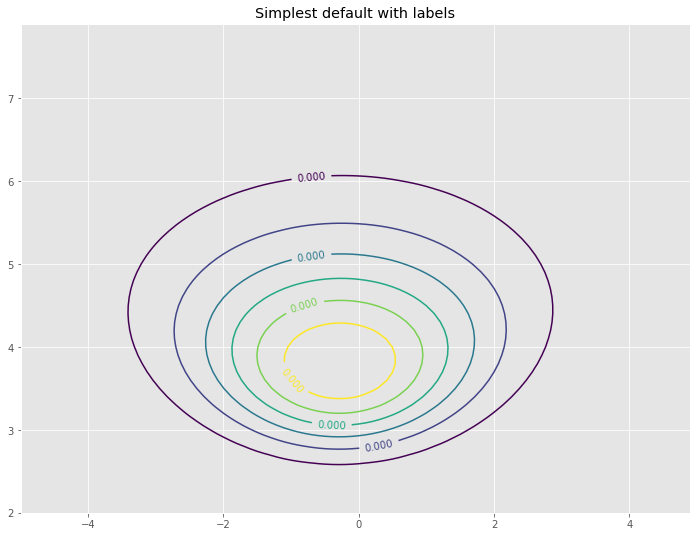

In [127]:
plt.figure(figsize=(12, 9))
CS = plt.contour(MU, SIGMA, reshaped_unlp)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')

In [25]:
likelihood(X, 0, 1)

6.530601016313034e-28